## Sentiment Analysis of Movie Reviews

By <br> 
Prashant Shrestha <br>
Student Number - 150199

This is a thsesis report on finding the sentiment analysis of movie reviews using Machine Learning and Deep Learning (BERT)

Importing the required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import rc
import json
import warnings
warnings.simplefilter('ignore')
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize 
import string
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from math import sqrt
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup,BertForSequenceClassification ,BertForPreTraining
import torch
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader


%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Reading the Amazon movie reviews Dataset

In [3]:
sourceFile = 'data/Movies_and_TV_5.json'

In [4]:
import json

# specify the path to your JSON file
filename = 'data/Movies_and_TV_5.json'

# open the file and read its contents
with open(filename, 'r') as file:
    data = json.load(file)
   # print(data[5])

Converting the dataset to a dataframe with necessary parameters of the dataset

In [5]:
df=pd.DataFrame()
df['text'] = [line['reviewText'] for line in data]
df['reviewerName'] = [line.get('reviewerName', 'N/A') for line in data]
df['overallscore'] = [line['overall'] for line in data]
df

,text,reviewerName,overallscore
0,It was good but not as emotionally moving as t...,Amarah Strack,3.0
1,"Don't get me wrong, Winkler is a wonderful cha...",Amazon Customer,3.0
2,Henry Winkler is very good in this twist on th...,"Amazon Customer ""Softmill""",5.0
3,This is one of the best Scrooge movies out. H...,BABE,4.0
4,This has been a favorite movie of mine for a l...,barbara whapeles,5.0
...,...,...,...
59189,"John Candy as the big hearted family man, Chet...","Sheila ChilcoteCollins ""Sheila Renee Chilcot...",4.0
59190,While this movie is typical 80s slaptstick wit...,sm,5.0
59191,Love the old school comedians and comedies. P...,"Stephen Liusa Young ""Stephen""",5.0
59192,Good family fun humor. Good acting with hilari...,Steve Hissong,4.0


Based on the overall score the a new column named 'Sentiment' is created and is labelled respectively

In [6]:
df.loc[df['overallscore']==5.0, 'sentiment'] = 'Positive'
df.loc[df['overallscore']==4.0, 'sentiment'] = 'Somewhat Positive'
df.loc[df['overallscore']==3.0, 'sentiment'] = 'Neutral'
df.loc[df['overallscore']==2.0, 'sentiment'] = 'Somewhat Negative'
df.loc[df['overallscore']==1.0, 'sentiment'] = 'Negative'

In [7]:
df

,text,reviewerName,overallscore,sentiment
0,It was good but not as emotionally moving as t...,Amarah Strack,3.0,Neutral
1,"Don't get me wrong, Winkler is a wonderful cha...",Amazon Customer,3.0,Neutral
2,Henry Winkler is very good in this twist on th...,"Amazon Customer ""Softmill""",5.0,Positive
3,This is one of the best Scrooge movies out. H...,BABE,4.0,Somewhat Positive
4,This has been a favorite movie of mine for a l...,barbara whapeles,5.0,Positive
...,...,...,...,...
59189,"John Candy as the big hearted family man, Chet...","Sheila ChilcoteCollins ""Sheila Renee Chilcot...",4.0,Somewhat Positive
59190,While this movie is typical 80s slaptstick wit...,sm,5.0,Positive
59191,Love the old school comedians and comedies. P...,"Stephen Liusa Young ""Stephen""",5.0,Positive
59192,Good family fun humor. Good acting with hilari...,Steve Hissong,4.0,Somewhat Positive


The dataset has been exported as CSV file and is being read again to the program.

In [8]:
df.to_csv(r'./data/reviews.csv')

In [9]:
df= pd.read_csv('data/reviews.csv')

A sample of the dataset is taken 

In [10]:
def sample (type, count):
    return df[df['overallscore']==type].sample(n=count)

df_reduced = pd.concat([sample(1,1000), sample(2,1000), sample(3,2000), sample(4,1000), sample(5,1000)])

In [11]:
df_reduced

,Unnamed: 0,text,reviewerName,overallscore,sentiment
20699,20699,The woman in this movie was no saint. How can ...,Patrick,1.0,Negative
59037,59037,I think Ben Stiller is a very talented individ...,jimmyrantsyahoo,1.0,Negative
40196,40196,When Highlander II came out people were walkin...,"S. J. Culbertson ""sjculb3""",1.0,Negative
19923,19923,"Horrible. Absolutely horrible in characters, ...","Douglas B. Moran ""Computer+History/Politics""",1.0,Negative
835,835,"Good grief, this movie was painful to watch an...",Linda,1.0,Negative
...,...,...,...,...,...
35020,35020,this movie is too hilarious to describe in suc...,Matthew S. Boros,5.0,Positive
22456,22456,Jackie Chan's favorite film that he has made. ...,M. Ferguson,5.0,Positive
52809,52809,"Its amazing how still to this day, a movie mad...","""themandgman""",5.0,Positive
27102,27102,I just finished watching this movie on HBO and...,Virtuous,5.0,Positive


Duplicate Values, NA values have been removed from the dataset

In [12]:
df_reduced=df_reduced.drop_duplicates()
df_reduced=df_reduced.reset_index(drop=True)
df = df.dropna(how='any',axis=0) 

In [13]:
df_reduced.reset_index(drop=True, inplace=True)
df_reduced.drop(df_reduced.columns[df_reduced.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df_reduced

,text,reviewerName,overallscore,sentiment
0,The woman in this movie was no saint. How can ...,Patrick,1.0,Negative
1,I think Ben Stiller is a very talented individ...,jimmyrantsyahoo,1.0,Negative
2,When Highlander II came out people were walkin...,"S. J. Culbertson ""sjculb3""",1.0,Negative
3,"Horrible. Absolutely horrible in characters, ...","Douglas B. Moran ""Computer+History/Politics""",1.0,Negative
4,"Good grief, this movie was painful to watch an...",Linda,1.0,Negative
...,...,...,...,...
5995,this movie is too hilarious to describe in suc...,Matthew S. Boros,5.0,Positive
5996,Jackie Chan's favorite film that he has made. ...,M. Ferguson,5.0,Positive
5997,"Its amazing how still to this day, a movie mad...","""themandgman""",5.0,Positive
5998,I just finished watching this movie on HBO and...,Virtuous,5.0,Positive


The missing values have been checked and n missing and null values are found in the dataset

In [14]:
df_reduced.isnull().sum()

text             0
reviewerName    13
overallscore     0
sentiment        0
dtype: int64

In [15]:
df_reduced.isna().sum()

text             0
reviewerName    13
overallscore     0
sentiment        0
dtype: int64

In [16]:
df_reduced['overallscore']=df_reduced['overallscore'].astype(int)
# df_reduced['overallscore']= df_reduced.dropna(subset=['overallscore']).astype(int)


Creating a function to assign overallscore below 2 as negative, 3 as neutral and above 3 as positive

In [17]:
def to_sentiment(overallscore):
    overallscore=int(overallscore)
    if overallscore <=2:
        return 'Negative'
    elif overallscore ==3:
        return 'Neutral'
    else:
        return 'Positive'

In [18]:
df_reduced["sentiment"]= df_reduced.overallscore.apply(to_sentiment)

In [19]:
class_names = ['negative', 'neutral', 'positive']

A plot has been created to represent the class balance of the dataset taken.

Negative    2000
Neutral     2000
Positive    2000
dtype: int64


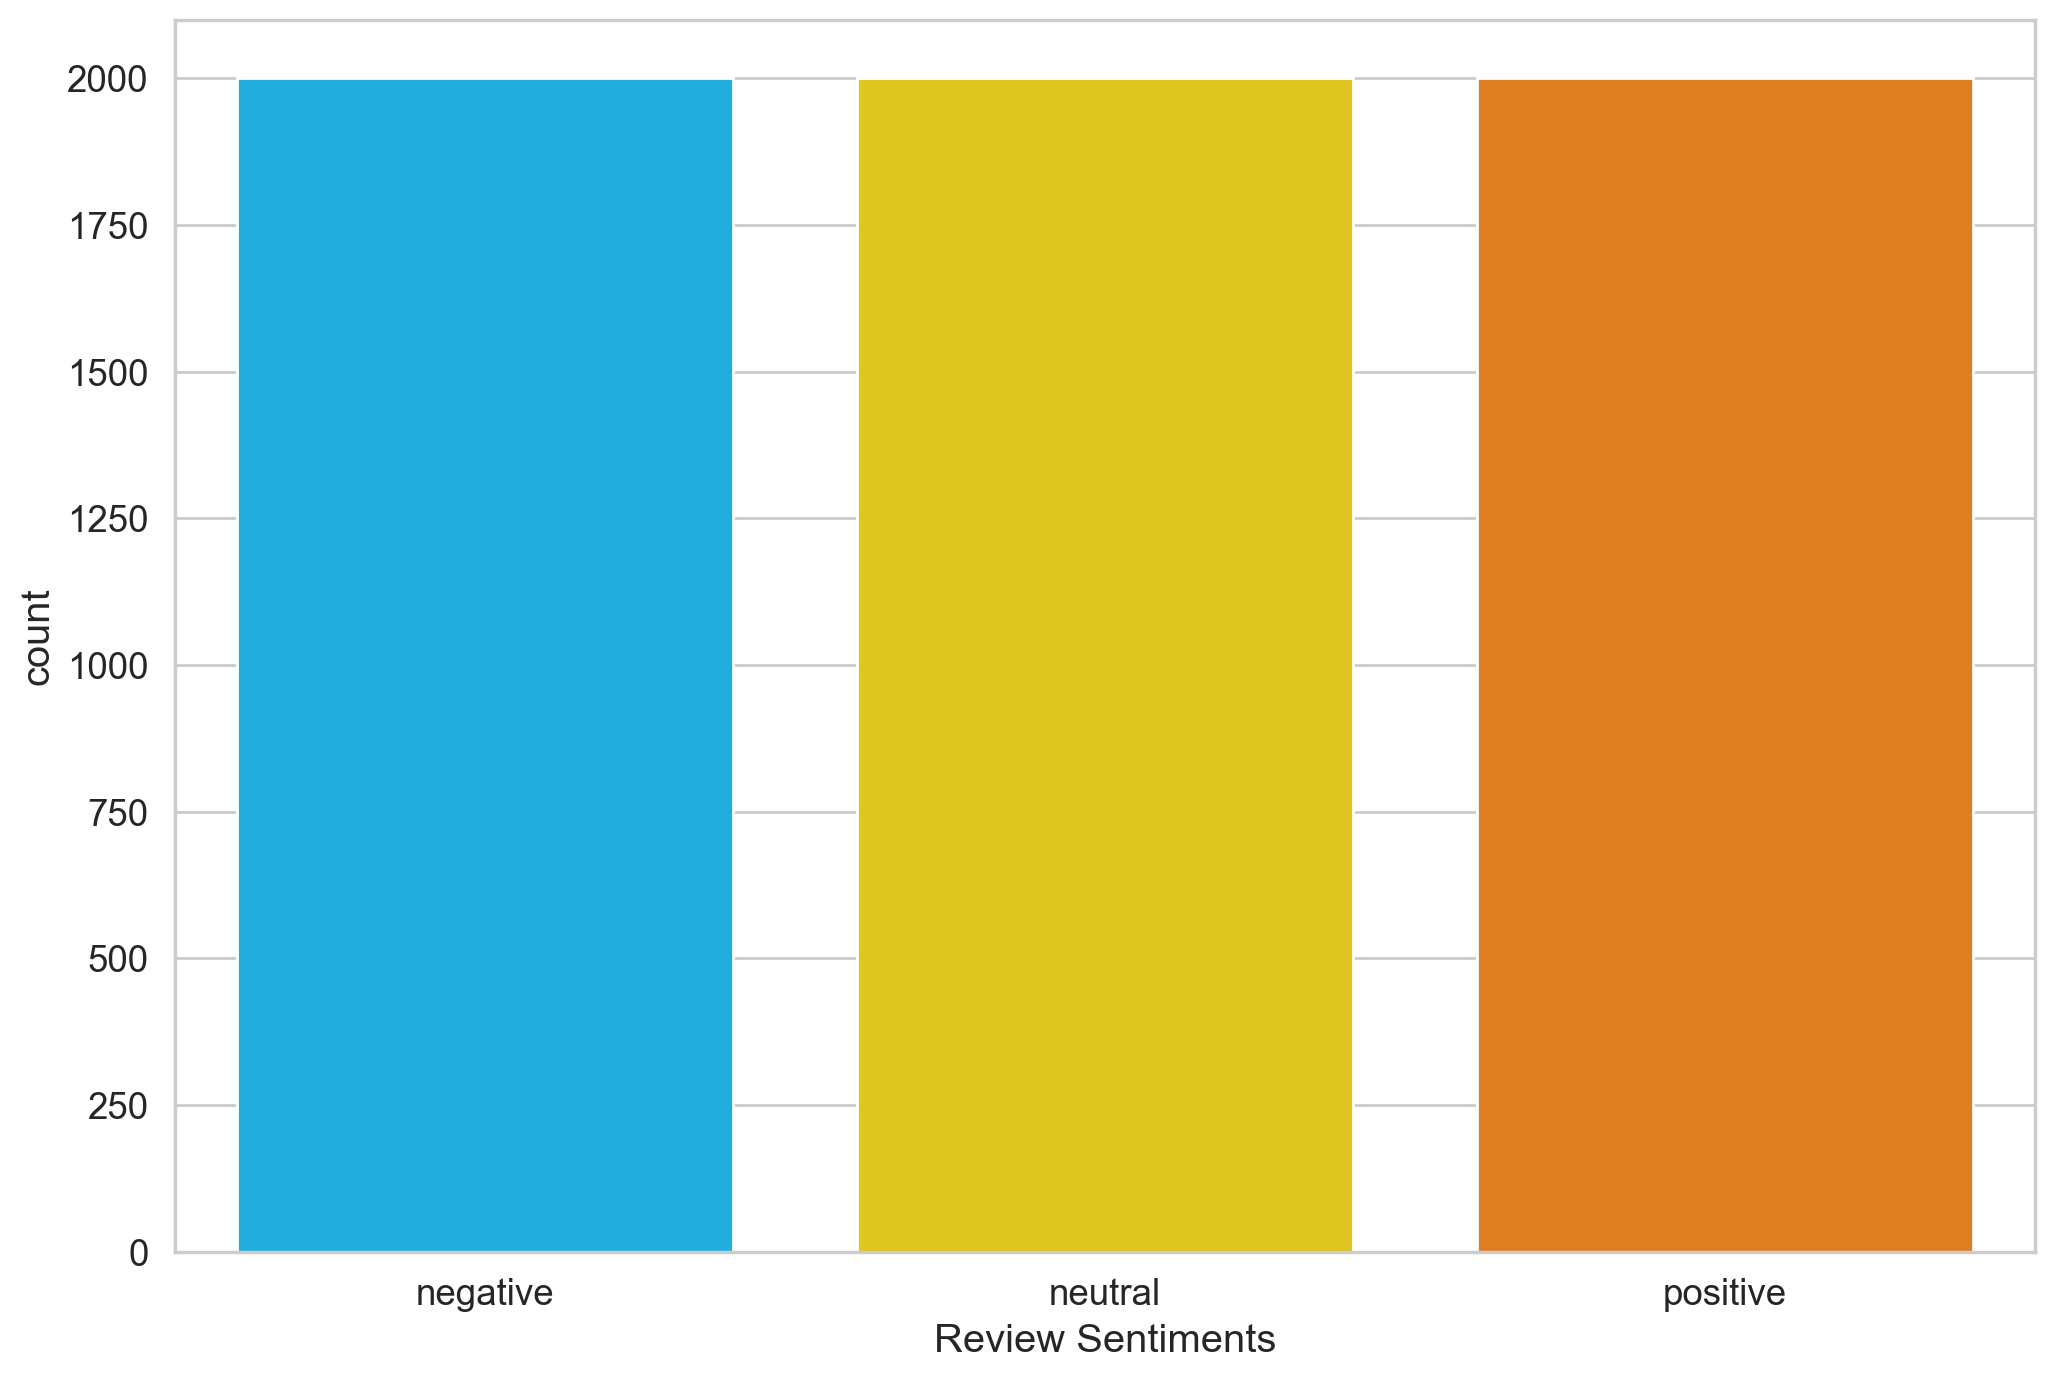

In [20]:
ax=sns.countplot(df_reduced['sentiment'])
word_count=pd.value_counts(df_reduced['sentiment'].values, sort=True)
print(word_count)
plt.xlabel('Review Sentiments')
ax.set_xticklabels(class_names)
plt.savefig('class_balanced.png')

A function named 'Preprocessing' has been created for text cleaning and text pre-prcessing of the reviews before applying to machine learning algorithm 

In [21]:
# import the necessary libraries 
import nltk 
import string 
import re 


#Converting the sentence into lower case

def text_lowercase(text):
    if not isinstance(text, str):
        return text
    return text.lower()
  

# Remove numbers 
def remove_numbers(text): 
	result = re.sub(r'\d+', '', text) 
	return result 

# import the inflect library 
import inflect 
p = inflect.engine() 

# convert number into words 
def convert_number(text): 
	# split string into list of words 
	temp_str = text.split() 
	# initialise empty list 
	new_string = [] 

	for word in temp_str: 
		# if word is a digit, convert the digit 
		# to numbers and append into the new_string list 
		if word.isdigit(): 
			temp = p.number_to_words(word) 
			new_string.append(temp) 

		# append the word as it is 
		else: 
			new_string.append(word) 

	# join the words of new_string to form a string 
	temp_str = ' '.join(new_string) 
	return temp_str 

# Expand the contraction terms
contractions_dict = {
        "ain't":"is not",
        "aint" : "is not",
        "amn't":"am not",
        "aren't":"are not",
        "arent":"are not,",
        "can't":"cannot",
        "cant":"cannot",
        "cause":"because",
        "couldn't":"could not",
        "couldn't've":"could not have",
        "could've":"could have",
        "daren't":"dare not",
        "daresn't":"dare not",
        "dasn't":"dare not",
        "didn't":"did not",
        "doesn't":"does not",
        "don't":"do not",
        "dont":"do not",
        "didnt":"did not",
        "doesnt":"does not",
        "e'er":"ever",
        "em":"them",
        "everyone's":"everyone is",
        "finna":"fixing to",
        "gimme":"give me",
        "gonna":"going to",
        "gon't":"go not",
        "gotta":"got to",
        "hadn't":"had not",
        "hasn't":"has not",
        "haven't":"have not",
        "he'd":"he would",
        "he'll":"he will",
        "he's":"he is",
        "he've":"he have",
        "how'd":"how would",
        "how'll":"how will",
        "how're":"how are",
        "how's":"how is",
        "I'd":"I would",
        "i'd":"i would",
        "I'll":"I will",
        "i'll":'i will',
        "I'm":"I am",
        "i'm":"i am",
        "I'm'a":"I am about to",
        "I'm'o":"I am going to",
        "isn't":"is not",
        "isnt":"is not",
        "it'd":"it would",
        "it'll":"it will",
        "itll":"it will",
        "it's":"it is",
        "i've":'i have',
        "I've":"I have",
        "kinda":"kind of",
        "let's":"let us",
        "lets":"let us",
        "mayn't":"may not",
        "may've":"may have",
        "mightn't":"might not",
        "might've":"might have",
        "mustn't":"must not",
        "mustn't've":"must not have",
        "must've":"must have",
        "needn't":"need not",
        "ne'er":"never",
        "o'":"of",
        "o'er":"over",
        "ol'":"old",
        "oughtn't":"ought not",
        "shalln't":"shall not",
        "shan't":"shall not",
        "shant":"shall not",
        "she'd":"she would",
        "she'll":"she will",
        "she's":"she is",
        "shouldn't":"should not",
        "shouldnt":"should not",
        "shouldn't've":"should not have",
        "shouldntve":"should not have",
        "should've":"should have",
        "shouldve":"should have",
        "somebody's":"somebody is",
        "someone's":"someone is",
        "something's":"something is",
        "that'd":"that would",
        "that'll":"that will",
        "that're":"that are",
        "that's":"that is",
        "there'd":"there would",
        "there'll":"there will",
        "there're":"there are",
        "there's":"there is",
        "these're":"these are",
        "they'd":"they would",
        "they'll":"they will",
        "they're":"they are",
        "they've":"they have",
        "this's":"this is",
        "those're":"those are",
        "'tis":"it is",
        "'twas":"it was",
        "wanna":"want to",
        "wasn't":"was not",
        "wasnt":"was not",
        "we'd":"we would",
        "we'd've":"we would have",
        "we'll":"we will",
        "we're":"we are",
        "weren't":"were not",
        "we've":"we have",
        "what'd":"what did",
        "what'll":"what will",
        "what're":"what are",
        "what's":"what is",
        "what've":"what have",
        "when's":"when is",
        "where'd":"where did",
        "where're":"where are",
        "where's":"where is",
        "where've":"where have",
        "which's":"which is",
        "who'd":"who would",
        "who'd've":"who would have",
        "who'll":"who will",
        "who're":"who are",
        "who's":"who is",
        "who've":"who have",
        "why'd":"why did",
        "why're":"why are",
        "why's":"why is",
        "won't":"will not",
        "wont":"will not",
        "wouldn't":"would not",
        "wouldnt":"would not",
        "would've":"would have",
        "wouldve":"would have",
        "y'all":"you all",
        "you'd":"you would",
        "you'll":"you will",
        "you're":"you are",
        "you've":"you have",
        "1st":"first",
        "2nd":"second",
        "cus":"because",
        "cuz":"because",
        "u":"you",
        "ff": "fast forward",
        "yrslf":"yourself",
        "hoped":"hope",
        "here's":"here is",
        "romcom":"romantic comedy",
        "rom-com":"romantic comedy"
        }
def contraction_expand(text):
    text=text.split()
    for i in range(0, len(text)):
        
        if text[i] in contractions_dict:
            text[i] = contractions_dict[text[i]]
    mess = ' '.join(text)
    return(mess) 

# remove punctuation 
def remove_punctuation(text): 
	translator = str.maketrans('', '', string.punctuation) 
	return text.translate(translator) 

# Remove Special Characters
def remove_special_characters(text):
    replaced = re.sub("[^a-z ]+.", '', text)
    return(replaced)

# Remove Special Characters
def remove_special_character(text):
    replaced = re.sub(">", '', text)
    return(replaced)

# remove escape characters
def remove_escape_characters(text):
    replaced = re.sub("[\\n\\t]+", '', text)
    return(replaced)

# remove whitespace from text 
def remove_whitespace(text): 
	return " ".join(text.split()) 


from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

# remove stopwords function 
def remove_stopwords(text):
    operators = set(('not','never', 'no','because','off','until','very'))
    stop = set(stopwords.words('english'))-operators
    nostopwords = [word for word in text.split() if word.lower() not in stop]
    nostopwords = ' '.join(nostopwords)
    return nostopwords


 
# Lemmatization
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize 
lemmatizer = WordNetLemmatizer() 
# lemmatize string 
def lemmatize_word(text): 
	word_tokens = word_tokenize(text) 
	# provide context i.e. part-of-speech 
	lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in word_tokens] 
	return lemmas 


def Preprocessing(input_str):
    input_str = text_lowercase(input_str)
    input_str = contraction_expand(input_str)
    input_str = convert_number(input_str)
    input_str = remove_numbers(input_str)
    input_str = remove_punctuation(input_str)
    input_str = remove_whitespace(input_str) 
    input_str = remove_escape_characters(input_str)
    input_str = remove_special_characters(input_str)
    input_str = remove_special_character(input_str)
    input_str = remove_stopwords(input_str)
    input_str = lemmatize_word(input_str)
    return input_str


Checking the pre-processed text data on a sample review.

In [22]:
print(df_reduced['text'][11])

If you want to see a movie that tries way too hard to be charming (but isn't), with lots of improv stories that are meant to be clever (but aren't), and you are willing to sit and patiently give occasional courtesy laughs (at best) for the length of a feature film, then you'll love this one.  Seriously, by the end I was rolling my eyes whenever a character began yet another pointless, unbelievable and supposedly "charming" recollection/story.Good points:  the music and the singing (particularly Streep's vocal performances  is there anything this woman can't do?).Bad points:  pretty much everything else.I guess there's a reason that PHC is a radio show.  Should've stayed that way.


In [23]:
print(Preprocessing(df_reduced['text'][11]))

['want', 'see', 'movie', 'try', 'way', 'hard', 'charm', 'isnt', 'lot', 'improv', 'stories', 'mean', 'clever', 'arent', 'will', 'sit', 'patiently', 'give', 'occasional', 'courtesy', 'laugh', 'best', 'length', 'feature', 'film', 'love', 'one', 'seriously', 'end', 'roll', 'eye', 'whenever', 'character', 'begin', 'yet', 'another', 'pointless', 'unbelievable', 'supposedly', 'charm', 'recollectionstorygood', 'point', 'music', 'sing', 'particularly', 'streeps', 'vocal', 'performances', 'anything', 'woman', 'can', 'not', 'dobad', 'point', 'pretty', 'much', 'everything', 'elsei', 'guess', 'reason', 'phc', 'radio', 'show', 'stay', 'way']


Dividing the dataset into training (80%) and test dataset (20%)

In [24]:
from sklearn.model_selection import train_test_split
X = df_reduced['text']
y = df_reduced['sentiment']
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)


In [25]:
df_reduced['text_prep'] = df_reduced['text'].astype(str).apply(lambda x:Preprocessing(x))
df_reduced.head()

,text,reviewerName,overallscore,sentiment,text_prep
0,The woman in this movie was no saint. How can ...,Patrick,1,Negative,"[woman, movie, no, saint, anybody, sign, faith..."
1,I think Ben Stiller is a very talented individ...,jimmyrantsyahoo,1,Negative,"[think, ben, stiller, very, talented, individu..."
2,When Highlander II came out people were walkin...,"S. J. Culbertson ""sjculb3""",1,Negative,"[highlander, ii, come, people, walk, theaters,..."
3,"Horrible. Absolutely horrible in characters, ...","Douglas B. Moran ""Computer+History/Politics""",1,Negative,"[horrible, absolutely, horrible, character, st..."
4,"Good grief, this movie was painful to watch an...",Linda,1,Negative,"[good, grief, movie, painful, watch, difficult..."


Creation of Word Cloud

In [26]:
words = list(map(' '.join, df_reduced['text_prep']))
words = str(words)
split_word = " ".join([word for word in words.split()])

In [27]:
from wordcloud import WordCloud,STOPWORDS
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=3000,
                      height=2500
                     ).generate(split_word)

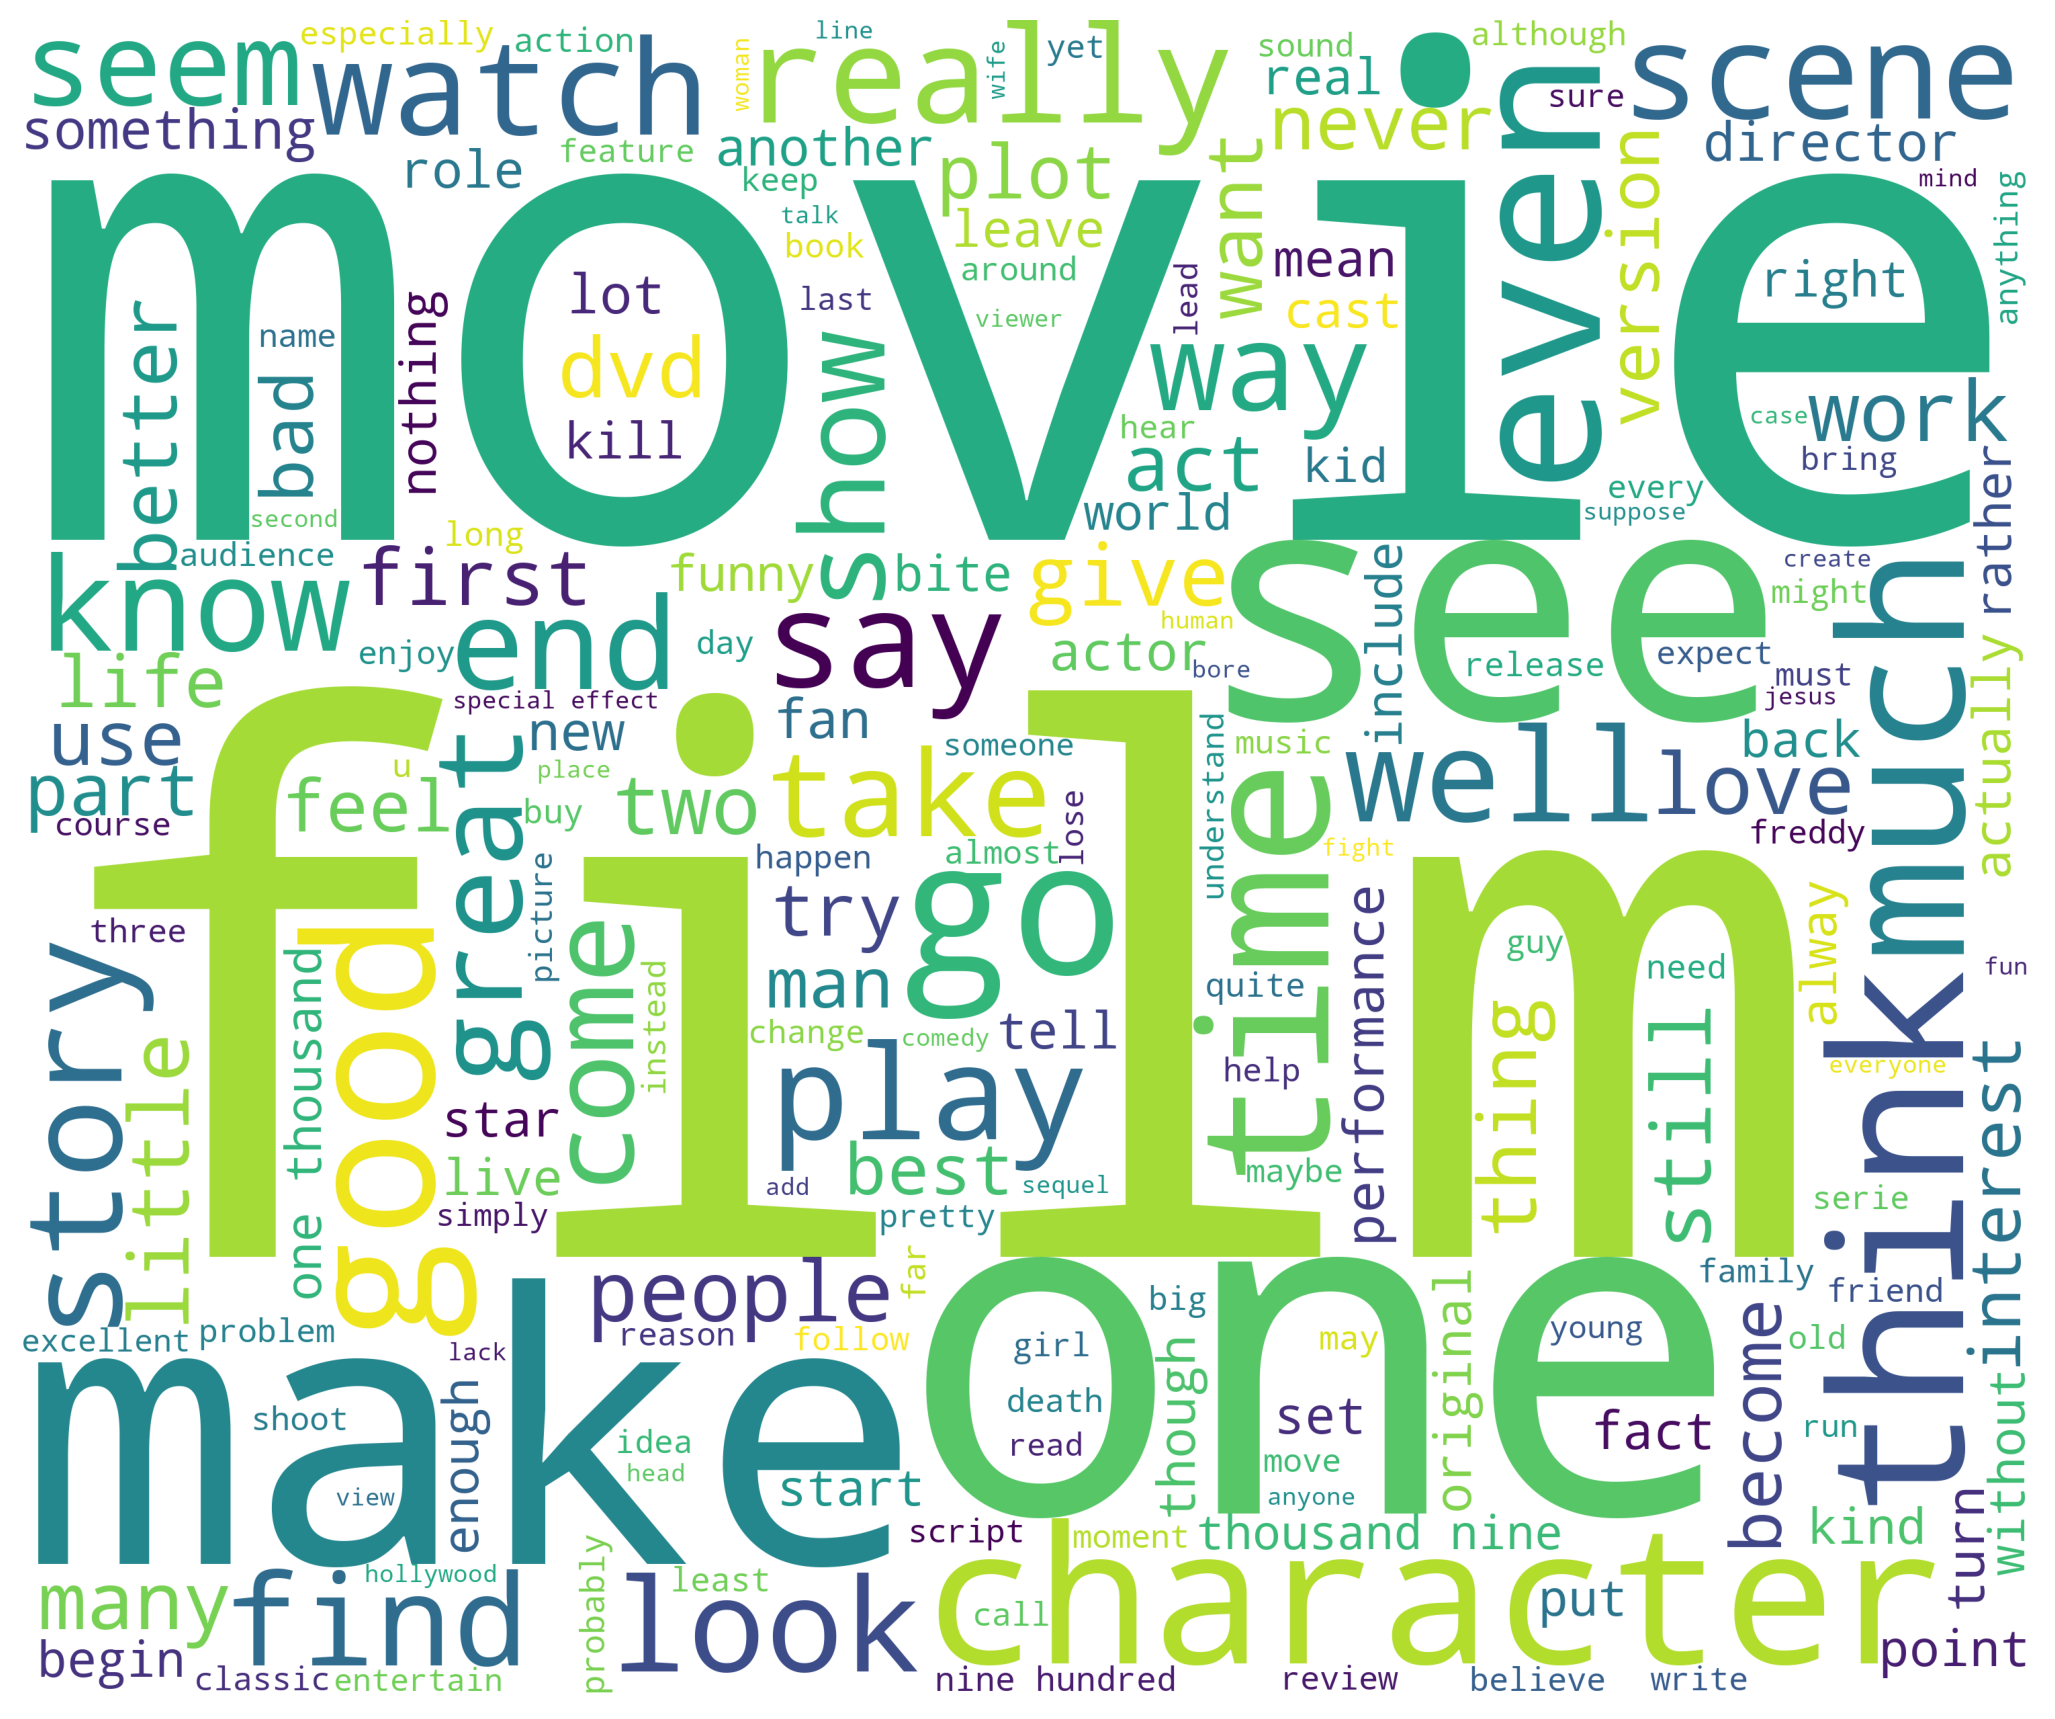

In [28]:
plt.figure(1,figsize=(13, 13))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
wordcloud.to_file('wordcloud1.png')

In [29]:
df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          6000 non-null   object
 1   reviewerName  5987 non-null   object
 2   overallscore  6000 non-null   int32 
 3   sentiment     6000 non-null   object
 4   text_prep     6000 non-null   object
dtypes: int32(1), object(4)
memory usage: 211.1+ KB


## Applying Machine Learning Algorithms

1. Naive Bayes Algorithm 

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB

In [31]:
pipeNB = Pipeline([
    ('bow',CountVectorizer(analyzer=Preprocessing)),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
])


In [32]:
# # Replace missing values with an empty string
x_train = x_train.fillna('')
y_train = y_train.fillna('')
# x_train = x_train.values.reshape((-1, 1))
x_test = x_test.fillna('')
# x_test = x_test.values.reshape((-1, 1))


In [33]:
pipeNB.fit(x_train,y_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function Preprocessing at 0x0000026290A27E50>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [34]:
pred = pipeNB.predict(x_test)

Classification Report of Naive Bayes Algorithm

In [35]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

    Negative       0.78      0.48      0.60       437
     Neutral       0.43      0.72      0.54       380
    Positive       0.69      0.52      0.59       383

    accuracy                           0.57      1200
   macro avg       0.63      0.57      0.58      1200
weighted avg       0.64      0.57      0.58      1200



Confusion Matrix of Naive Bayes Algorithm

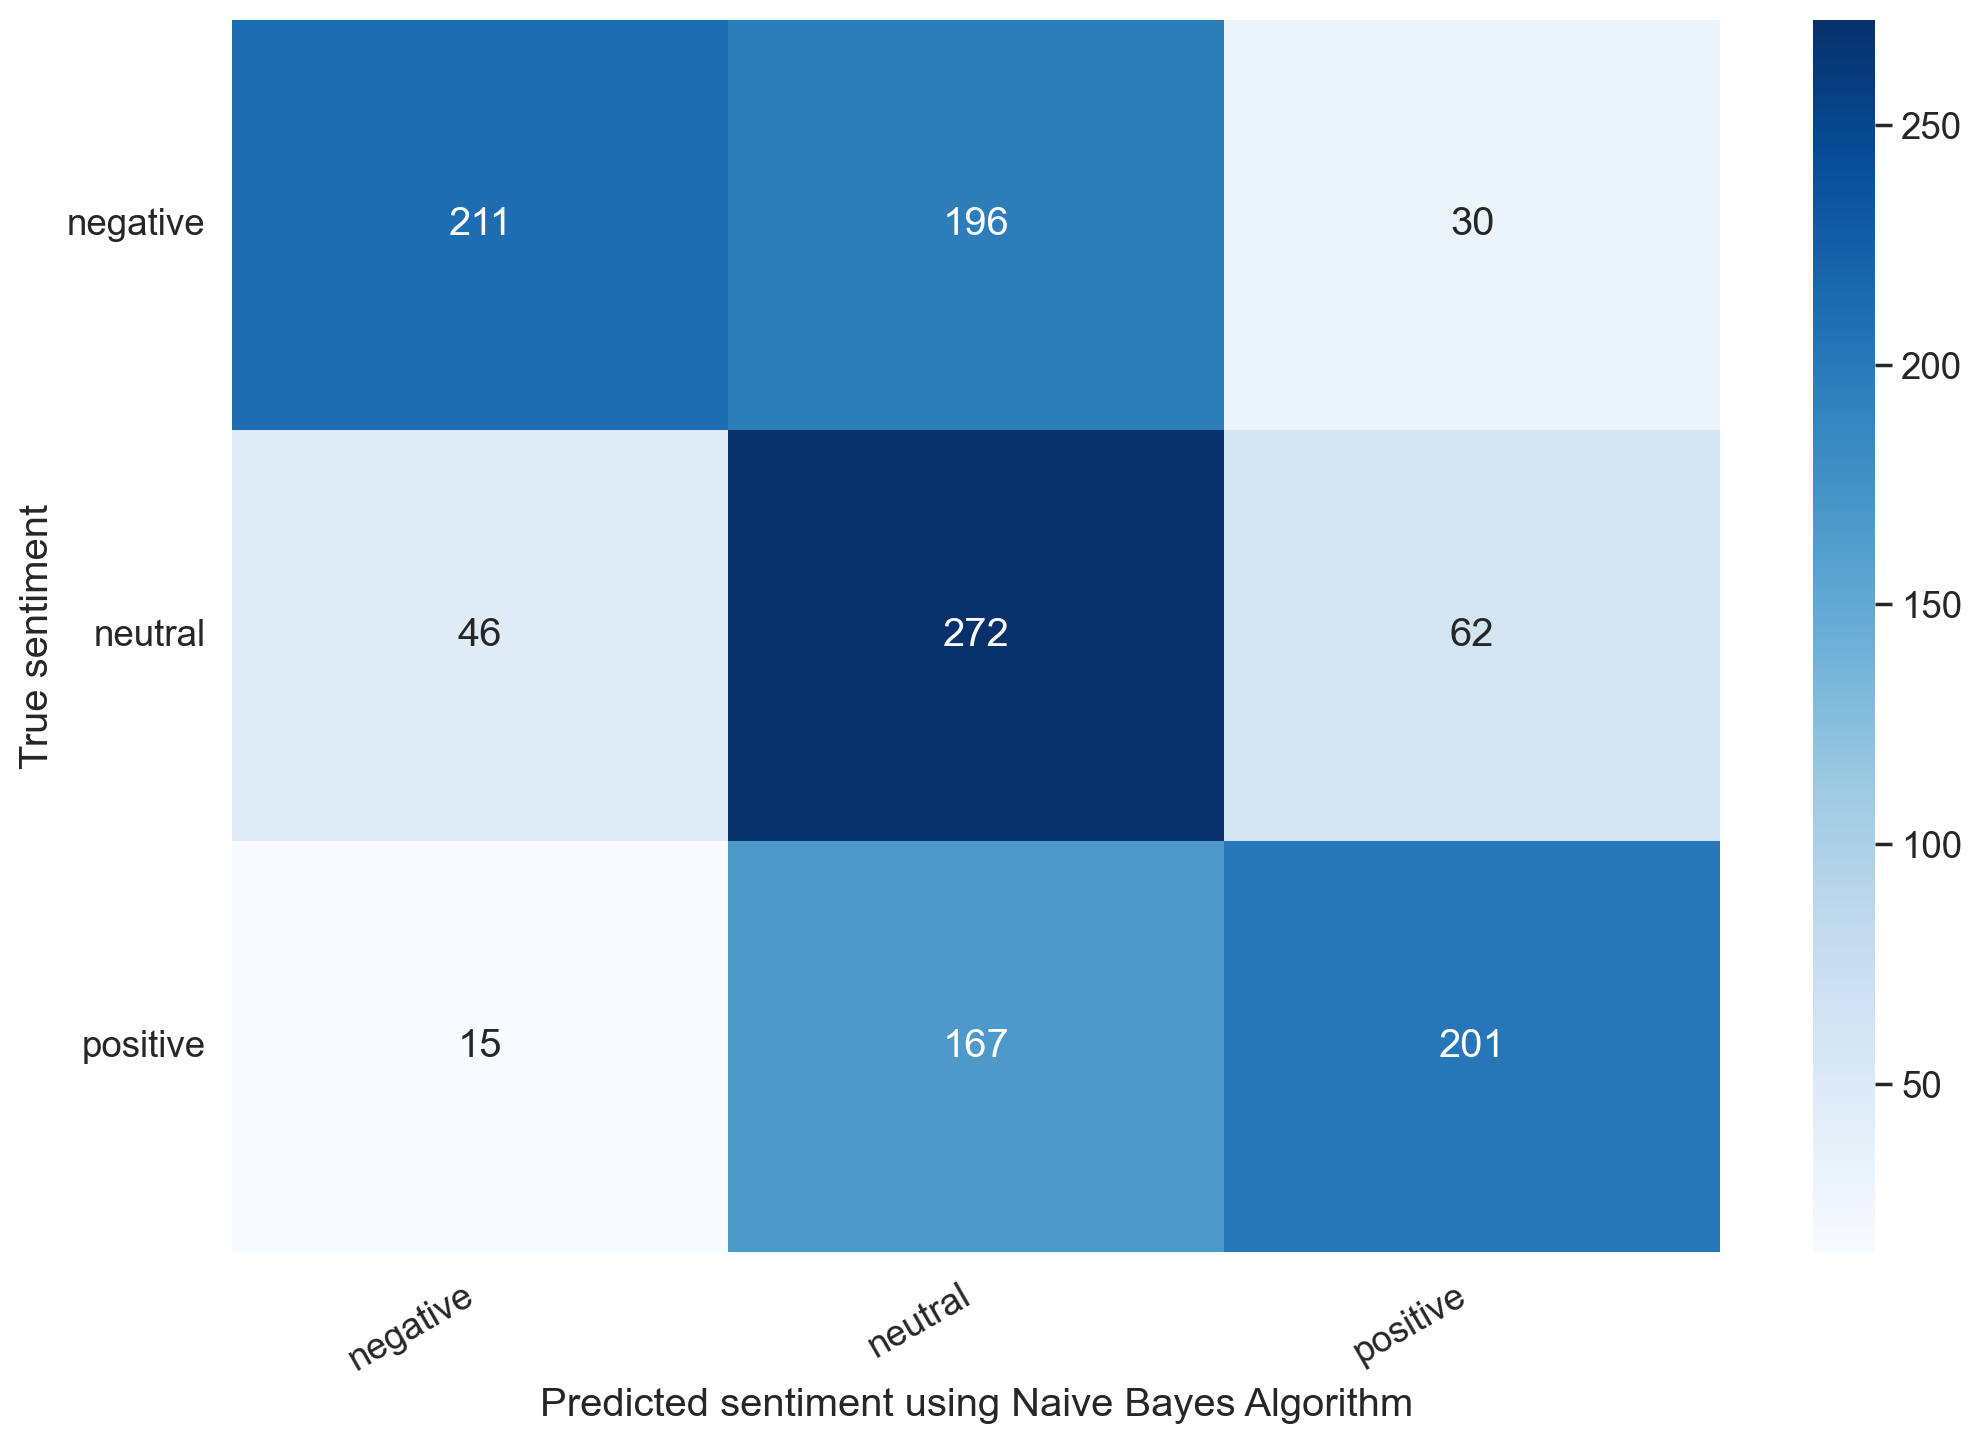

In [36]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment using Naive Bayes Algorithm');
cm = confusion_matrix(y_test,pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)
plt.savefig("confusion_matrix_Naive_Bayes.png")

2. Random Forest Algorithm


Classification Report of Random Forest

In [37]:
from sklearn.ensemble import RandomForestClassifier
pipeRFC = Pipeline([
    ('bow',CountVectorizer(analyzer=Preprocessing)),
    ('tfidf',TfidfTransformer()),
    ('classifier',RandomForestClassifier())
])

pipeRFC.fit(x_train,y_train)
pred = pipeRFC.predict(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

    Negative       0.69      0.67      0.68       437
     Neutral       0.49      0.45      0.47       380
    Positive       0.59      0.67      0.63       383

    accuracy                           0.60      1200
   macro avg       0.59      0.59      0.59      1200
weighted avg       0.60      0.60      0.60      1200



Confusion Matrix of Random Forest

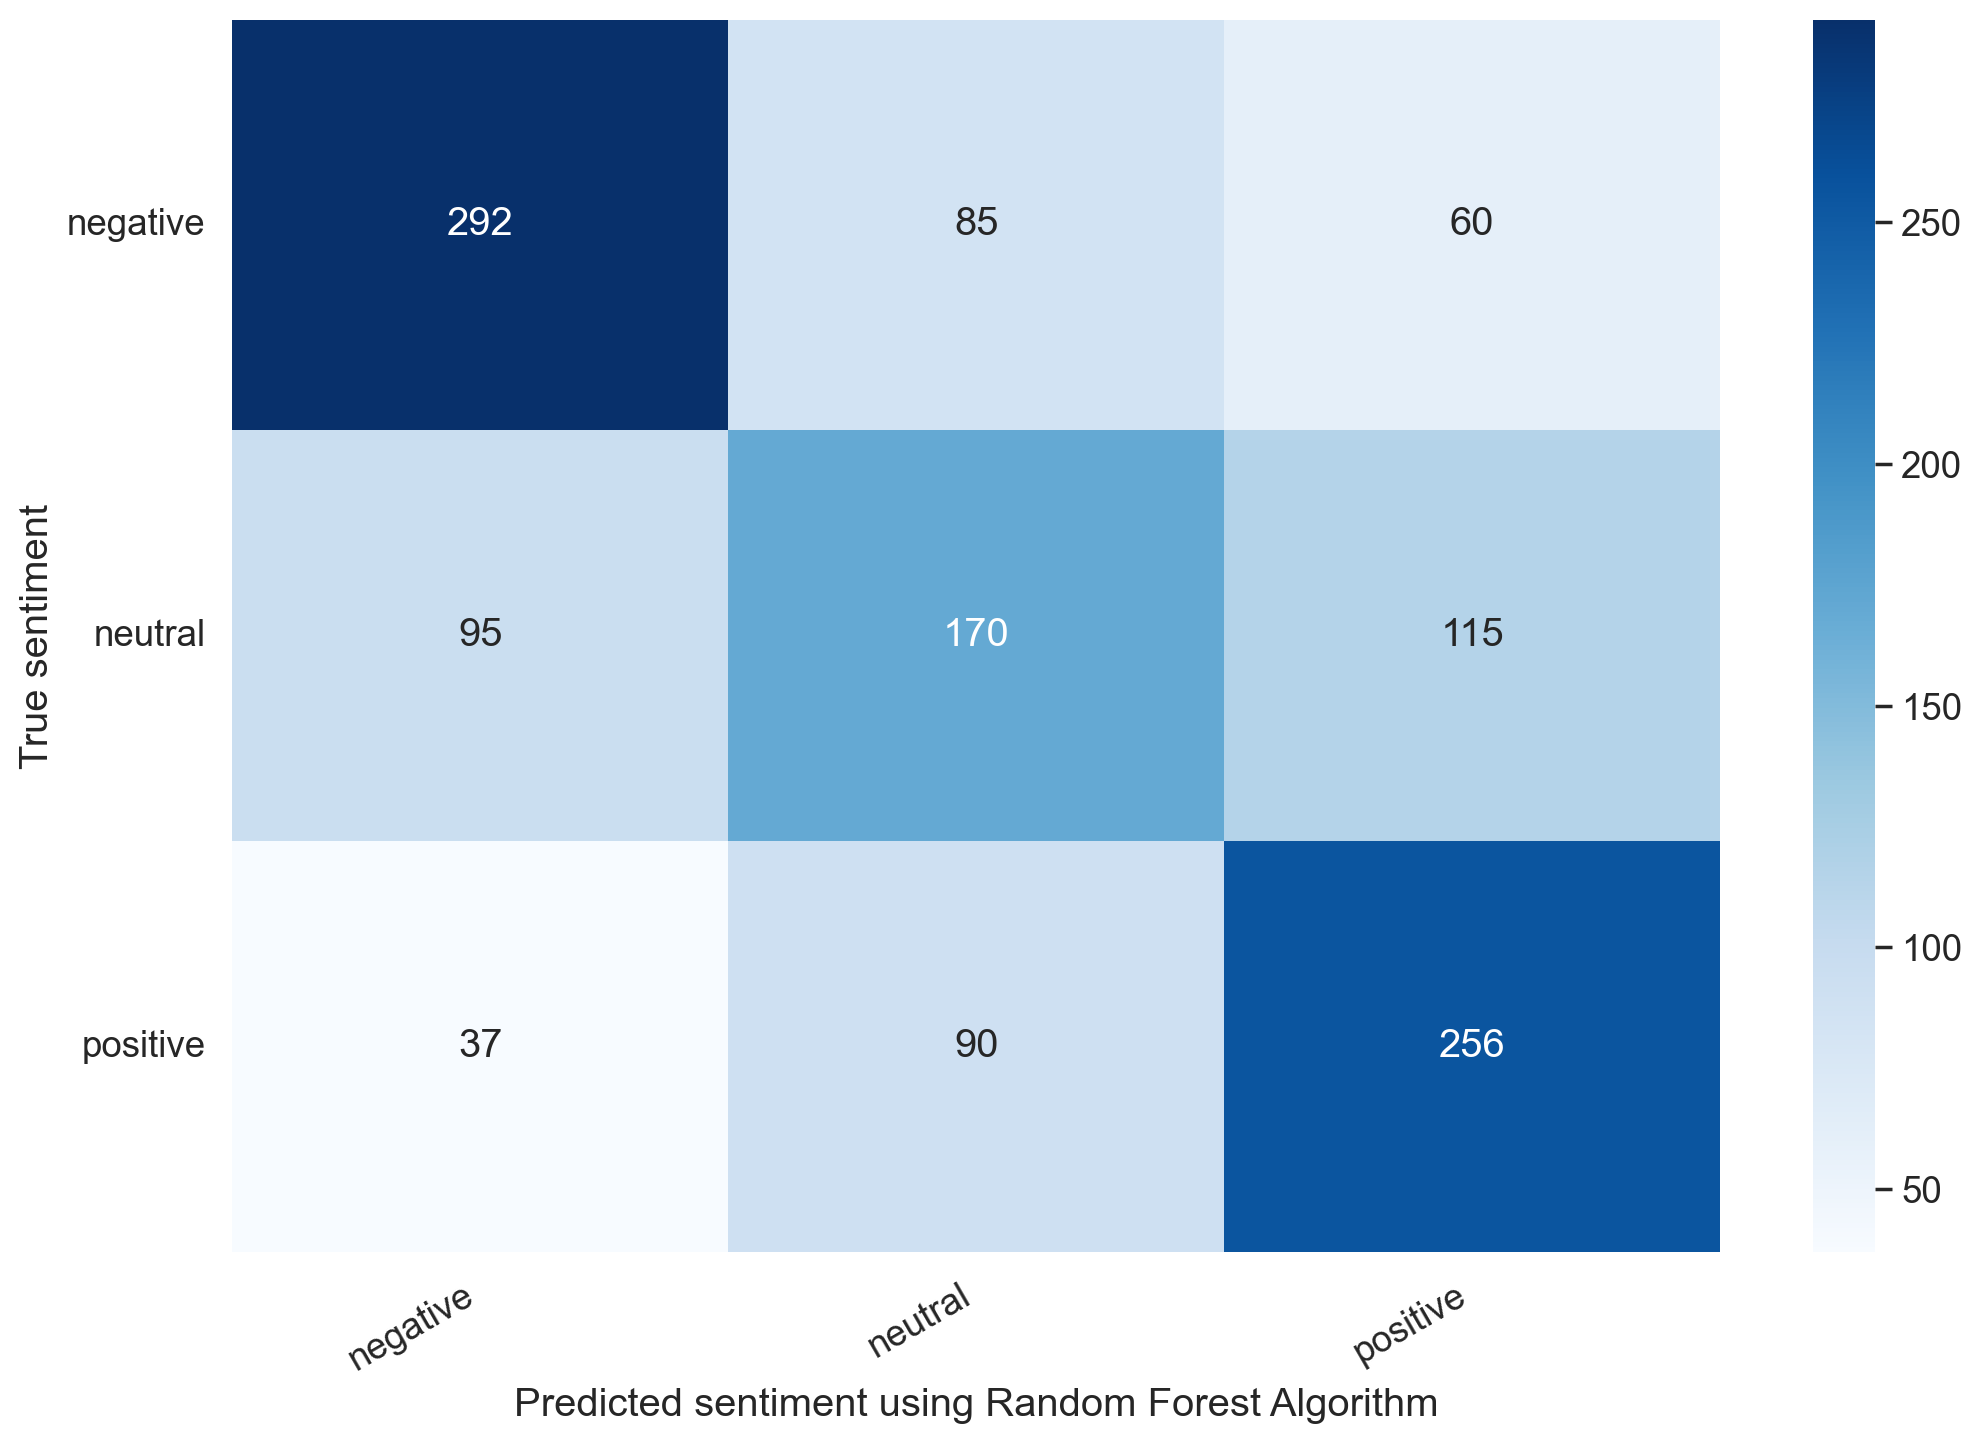

In [38]:
 def show_confusion_matrix(confusion_matrix):
   hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
   hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
   hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
   plt.ylabel('True sentiment')
   plt.xlabel('Predicted sentiment using Random Forest Algorithm');
cm = confusion_matrix(y_test,pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)
plt.savefig("confusion_matrix_RANDOMFOREST.png")

3. Support Vector Machine

Classification Report of Support Vector Machine Algorithm

In [39]:
from sklearn.svm import SVC
pipeSVM = Pipeline([
    ('bow',CountVectorizer(analyzer=Preprocessing)),
    ('tfidf',TfidfTransformer()),
    ('classifier',SVC(kernel='linear'))
])

pipeSVM.fit(x_train,y_train)
pred = pipeSVM.predict(x_test)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

    Negative       0.69      0.63      0.66       437
     Neutral       0.45      0.48      0.47       380
    Positive       0.65      0.67      0.66       383

    accuracy                           0.60      1200
   macro avg       0.60      0.59      0.59      1200
weighted avg       0.60      0.60      0.60      1200



Confusion Matrix of Support Vector Machine Algorithm

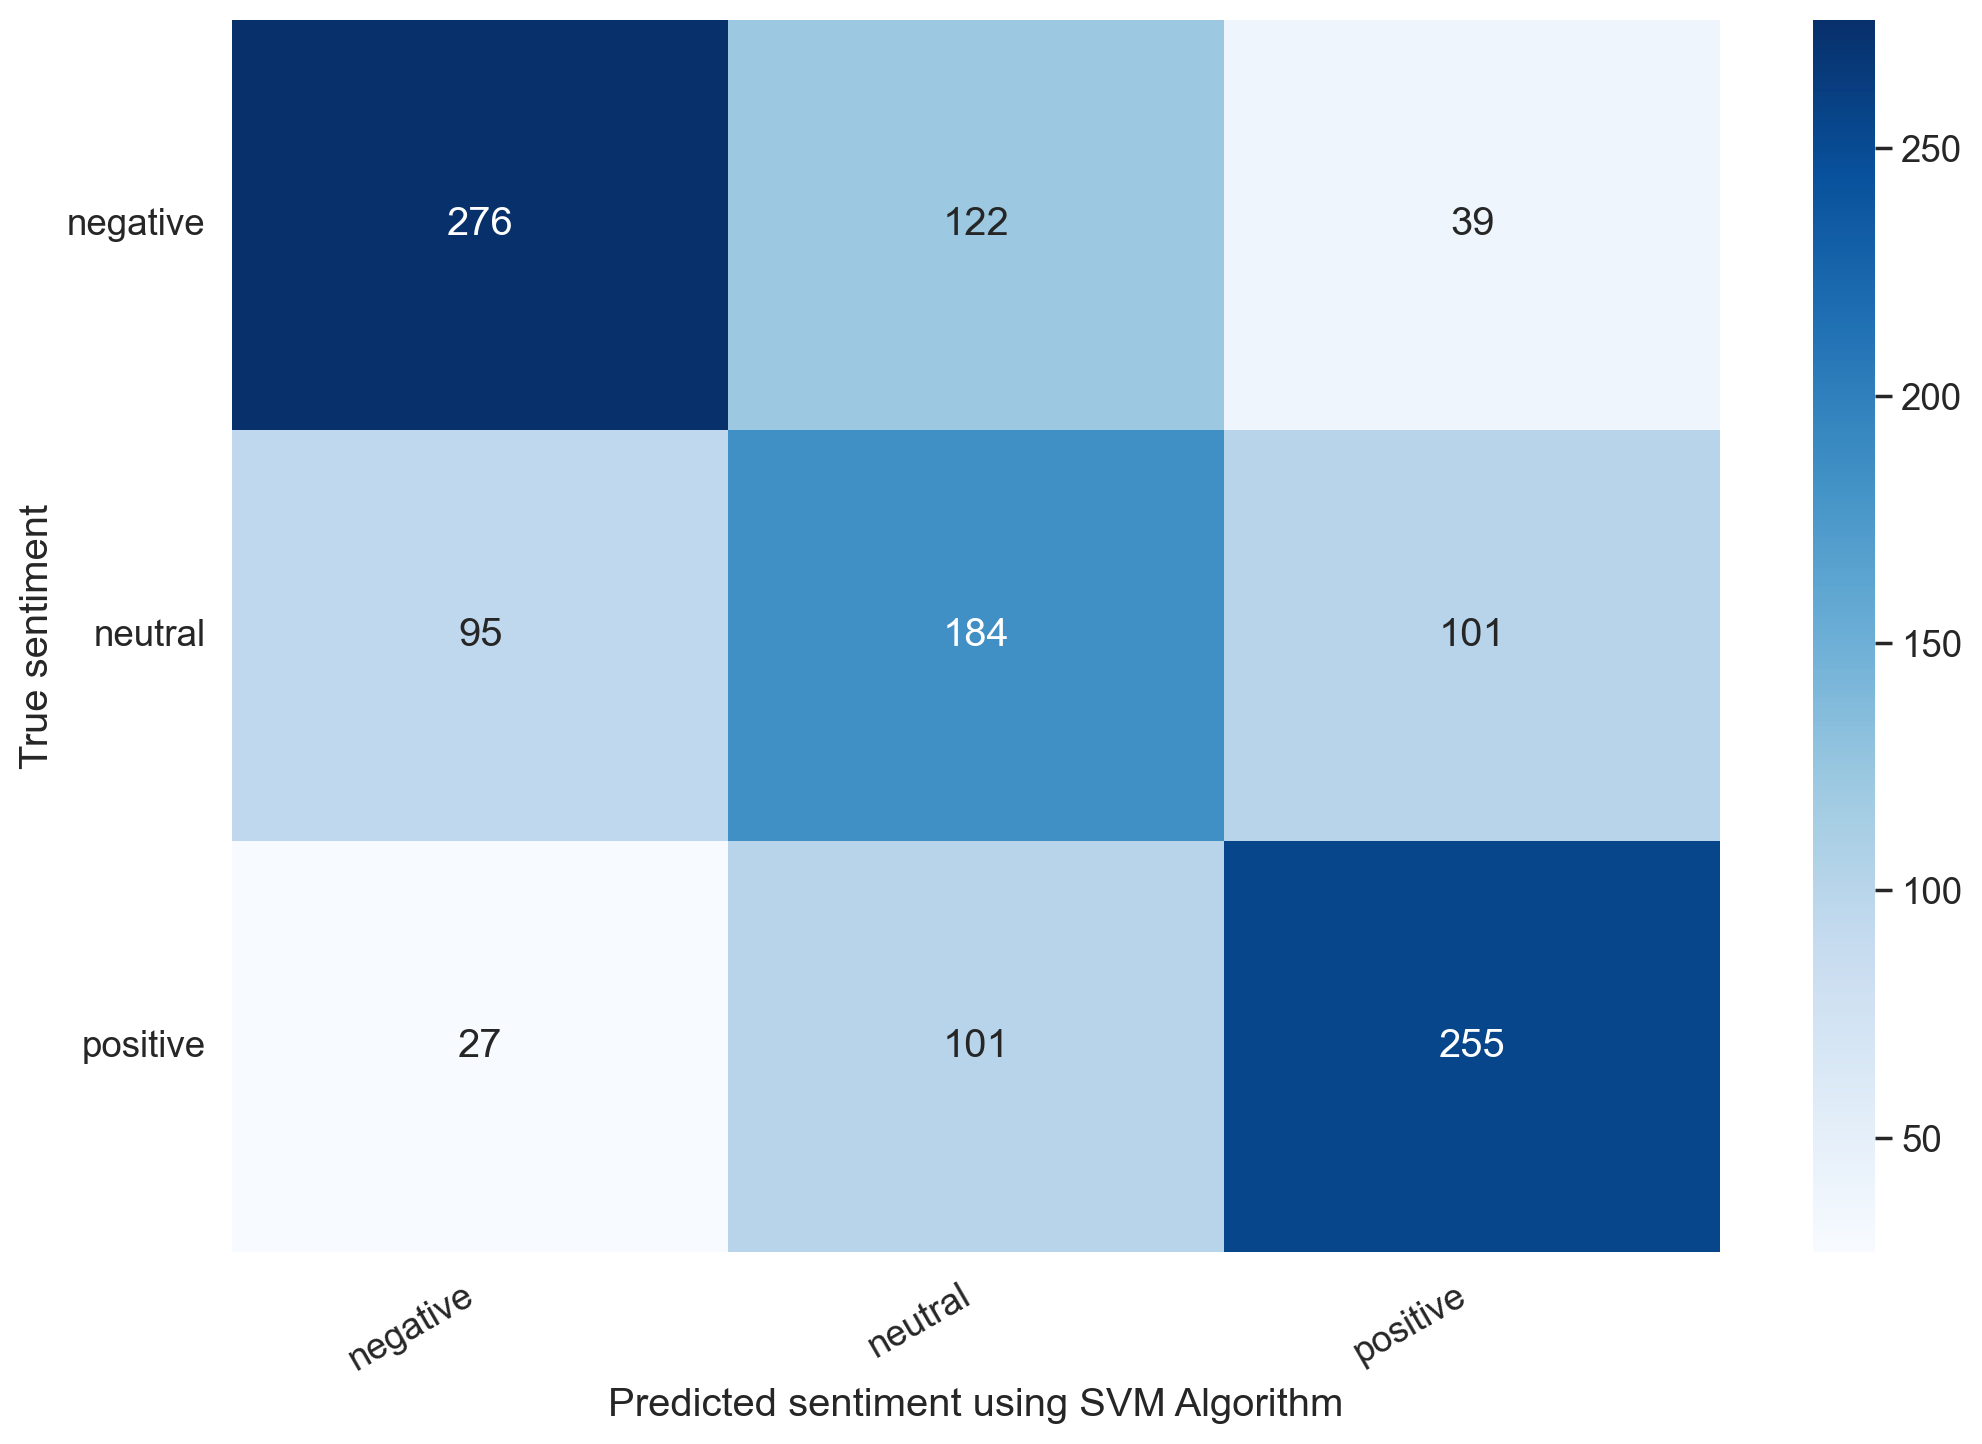

In [40]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment using SVM Algorithm');
cm = confusion_matrix(y_test,pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)
plt.savefig("confusion_matrix_SVM.png")

4. KNN Classifier


Classification Report of KNN Algorithm

In [41]:
from sklearn.neighbors import KNeighborsClassifier
pipeKNN = Pipeline([
    ('bow',CountVectorizer(analyzer=Preprocessing)),
    ('tfidf',TfidfTransformer()),
    ('classifier',KNeighborsClassifier(n_neighbors=3))
])
pipeKNN.fit(x_train,y_train)
pred = pipeKNN.predict(x_test)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

    Negative       0.48      0.58      0.52       437
     Neutral       0.39      0.34      0.37       380
    Positive       0.46      0.41      0.43       383

    accuracy                           0.45      1200
   macro avg       0.44      0.44      0.44      1200
weighted avg       0.45      0.45      0.44      1200



Confusion Matrix of KNN Algorithm

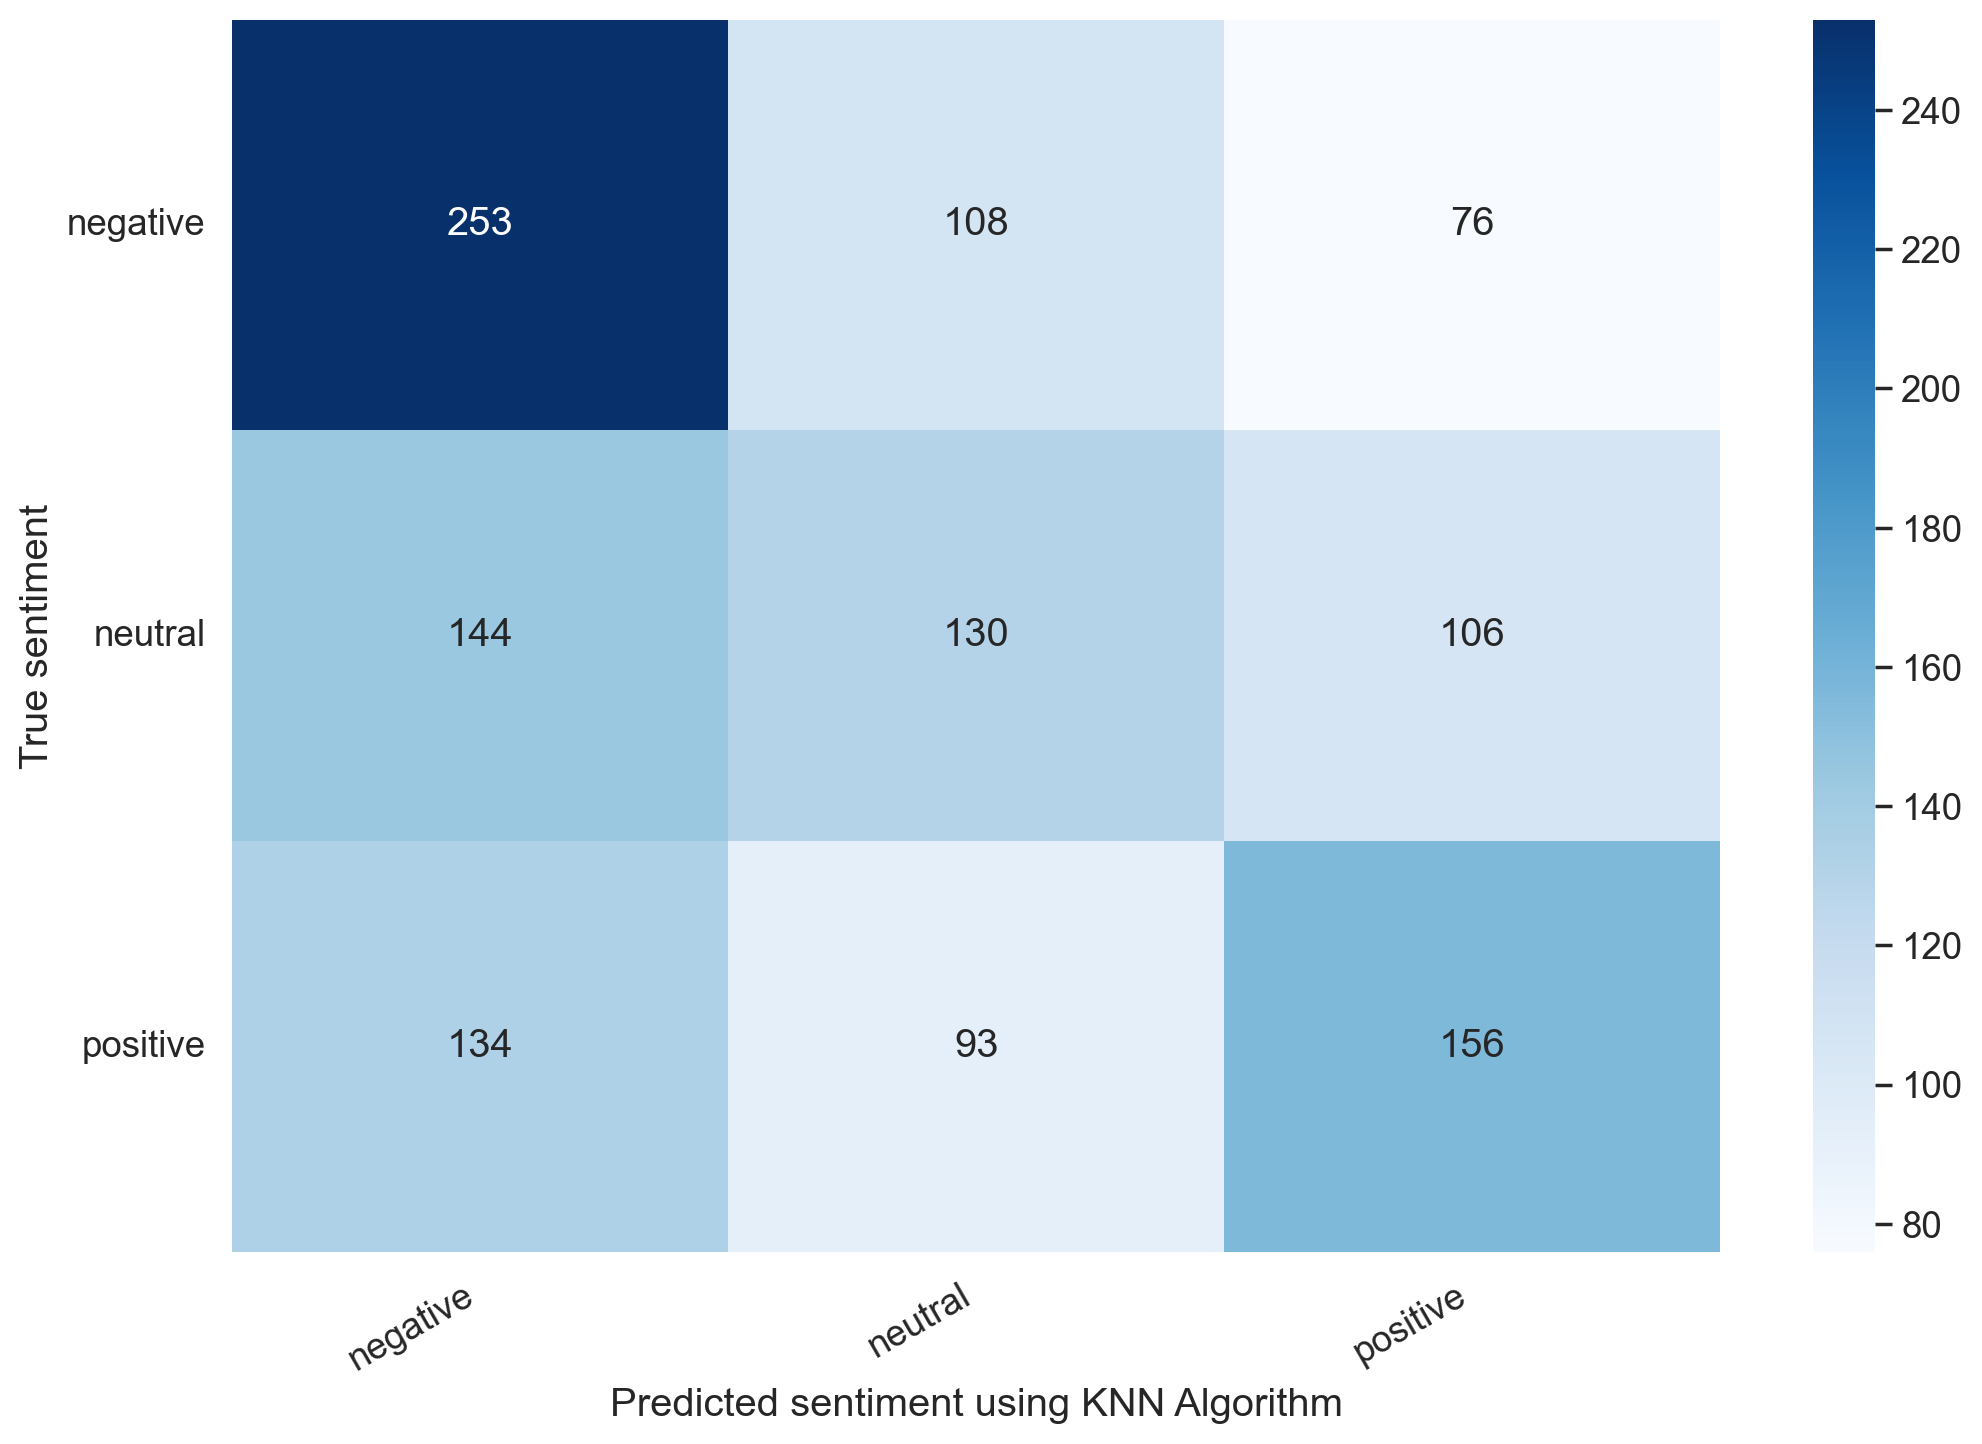

In [42]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment using KNN Algorithm');
cm = confusion_matrix(y_test,pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)
plt.savefig("confusion_matrix_KNN.png")